# Movie recommendation system
>Often, the question of different aspects of business including the reduction of customer attrition, expansion of market share, increment of sales, etcetera, are based on various approaches as  adopted by the underlying business. Such approaches might include but not limited to, conducting marketing campaigns tailored for various market segments, adoption of current customer satisfaction practices, use of recommendation tools, etc.

> Primarily, recommender systems as observed by Shetty [1], help users discover new movieIds as well as services. This implies that, a recommender system ought to be configured such that they recommend the best movieId (that is, most relevant movieId based on user interactions). To this end, recommender systems are essential especially in today’s world where most of the goods and services are digitalized which often leads to users being overwhelmed by choice and need help finding what they're looking for. The ease of recommendation will often lead to more satisfied users and hence more sales.
Uses of Recommender systems
Some of the applications of recommender systems include, recommending movies, music, television programs, books, documents, websites, conferences, tourism scenic spots and learning materials.

- ***Examples of recommendation systems are:***
    1. Offering news articles to on-line newspaper readers, based on a prediction
of reader interests.
    2. Offering customers of an on-line retailer suggestions about what they
might like to buy, based on their past history of purchases and/or movieId
searches.
    3. Recommending movies to user based on there previous watch 
    
    
   #### Objective
   >In practice, there are quite a number of recommender systems which are broadly categorized into traditional and modern recommender systems. 
In an article by Sciforce blog [2], it is noted that traditional recommender systems (RSs) include content-based and collaborative filtering (CF) systems grounding their recommendations on historical interactions and user/item attributes. Content-based recommendations are mainly drawn on the user’s item and profile features, and CF seeks a similar audience’s preferences. On the other hand, modern recommender systems are mainly based on deep learning techniques such as convolutional neural networks (CNNs) which [2] observes as being a good fit for  unstructured multimedia data processing given effective feature extraction.

##### Research Objective
>The current study proposes a deep learning based recommender systems for the recommendation of movies based on an individual’s previous movie ratings. Moreover, the proposed recommender system will be based on the web UI that is proposed to be developed using Django .



![](https://md.ekstrandom.net/talks/2014/txstate-recsys-research/movielens.png)

# Table Of Contents
- Exploratory Data Analysis(EDA)
- Content based filtering
- Deep Learning Models

## Load Libraries 

In [1288]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype
from scipy.sparse import  csr_matrix
import scipy.sparse as sparse
#Deep learning
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, merge
from keras.optimizers import RMSprop
from keras.regularizers import l2
from numpy import count_nonzero
from tableone import TableOne, load_dataset
from scipy import stats

# Dataset : Small Movielens
>Source: https://files.grouplens.org/datasets/movielens/ml-100k.zip

In [1289]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [1290]:
df_movie = movies 
df_ratings = ratings 

In [1291]:
df_movies1 = df_movie.merge(df_ratings)[['genres', 'rating']]

#### Examine data sparsity

In [1292]:
users = list(np.sort(ratings.userId.unique())) # Get our unique customers
movies = list(ratings.movieId.unique()) # Get our unique products that were purchased
rating = list(ratings.rating) # All of our purchases
rows = ratings.userId.astype('category', users).cat.codes
# Get the associated row indices
cols = ratings.movieId.astype('category', movies).cat.codes
# Get the associated column indices
user_item = sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(movies)))
matrix_size = user_item.shape[0]*user_item.shape[1] # Number of possible interactions in the matrix
num_purchases = len(user_item.nonzero()[0]) # Number of items interacted with

In [1293]:
print(num_purchases, 'interactions')

100836 interactions


In [1294]:
print(len(movies), 'Items')

9724 Items


In [1295]:
print(len(users), 'Users')

610 Users


## Exploratory Data Analysis(EDA)

In [1296]:
df_movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of movie released

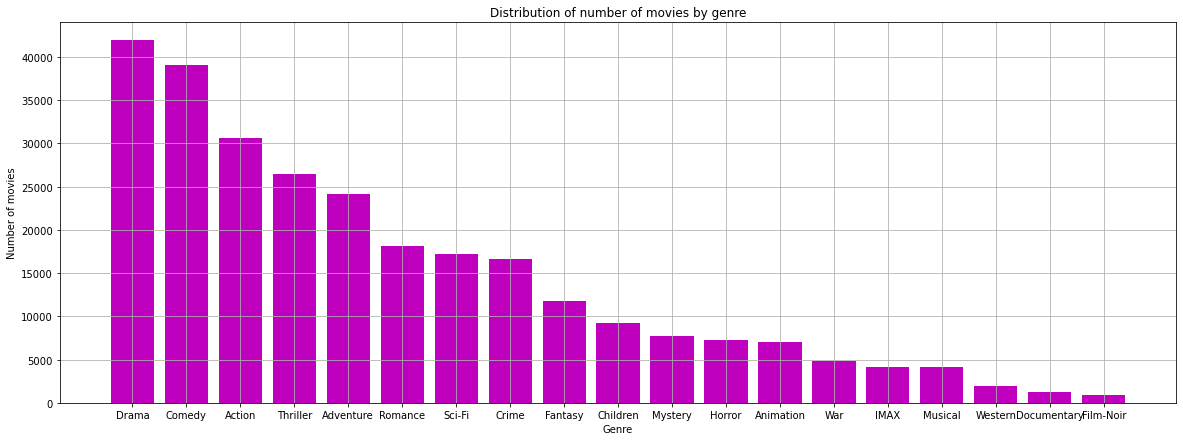

In [1297]:
plt.figure(figsize=(20,7))
genrelist = df_movies1['genres'].apply(lambda genrelist_movie : str(genrelist_movie).split("|"))
genres_count = {}

for genrelist_movie in genrelist:
    for genre in genrelist_movie:
        if(genres_count.get(genre,False)):
            genres_count[genre]=genres_count[genre]+1
        else:
            genres_count[genre] = 1
            
genres_count.pop('(no genres listed)')
genres_count = {k: v for k, v in sorted(genres_count.items(), key=lambda item: item[1], reverse=True)}
plt.bar(genres_count.keys(),genres_count.values(),color='m')
plt.title('Distribution of number of movies by genre')
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.grid()
plt.show()

In [1298]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Distribution of users rating

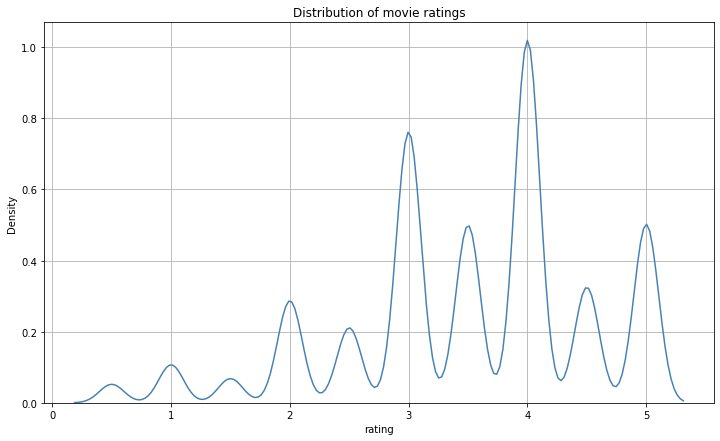

In [1299]:
plt.figure(figsize=(12,7))
sns.kdeplot(df_ratings["rating"], color = 'steelblue');
plt.title('Distribution of movie ratings')
plt.grid()
plt.show()

In [1300]:
print("Shape of the dataframes: \n"+ " Rating DataFrame: "+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movie.shape))

Shape of the dataframes: 
 Rating DataFrame: (100836, 4)
 Movies DataFrame(9742, 3)


In [1301]:
merge_movie_ratings = pd.merge(df_movie, df_ratings, on='movieId', how='inner')

In [1302]:
merge_movie_ratings.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962


In [1303]:
merge_movie_ratings = merge_movie_ratings.drop('timestamp', axis=1)

In [1304]:
merge_movie_ratings.shape

(100836, 5)

Grouping the rating based on user

In [1305]:
ratings_grouped_by_users = merge_movie_ratings.groupby('userId').agg([np.size, np.mean])

In [1306]:
ratings_grouped_by_users.head(2)

movieId               rating          
          size          mean   size      mean
userId                                       
1          232   1854.603448  232.0  4.366379
2           29  70350.275862   29.0  3.948276

In [1307]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

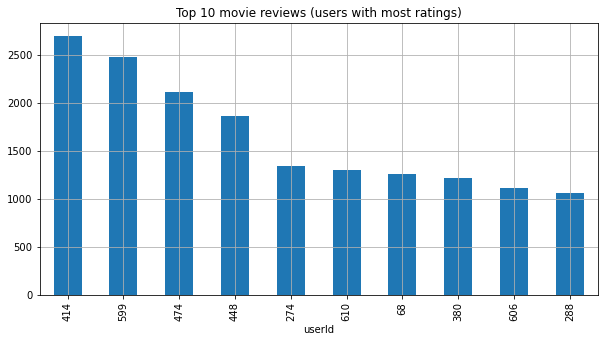

In [1308]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (10,5))
plt.title('Top 10 movie reviews (users with most ratings)')
plt.grid()
plt.show()

In [1309]:
ratings_grouped_by_movies = merge_movie_ratings.groupby('movieId').agg([np.mean], np.size)

In [1310]:
ratings_grouped_by_movies.shape

(9724, 2)

In [1311]:
ratings_grouped_by_movies.head(3)

,userId,rating
,mean,mean
movieId,,
1,306.530233,3.920930
2,329.554545,3.431818
3,283.596154,3.259615


In [1312]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

### Movies with high average rating

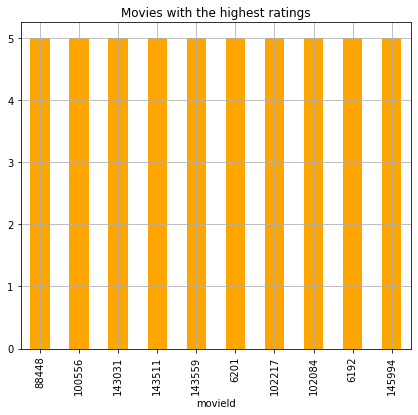

In [1313]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='bar',
                                                                                       figsize=(7,6), color = 'orange');
plt.title('Movies with the highest ratings')
plt.grid()
plt.show()

### Movies with low average rating

In [1314]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [1315]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

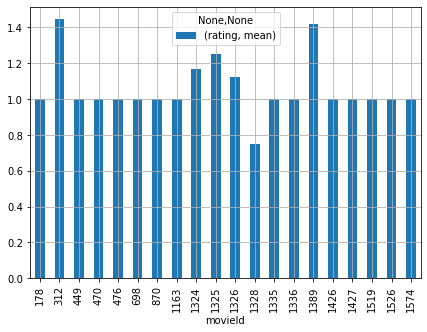

In [1316]:
low_rated_movies.head(20).plot(kind='bar', figsize=(7,5));
plt.grid()

In [1317]:
low_rated_movies.head(10)

,rating
,mean
movieId,
178,1.000000
312,1.444444
449,1.000000
470,1.000000
476,1.000000
698,1.000000
870,1.000000
1163,1.000000


In [1318]:
#Merge
df_movies = df_movie.merge(df_ratings)

groupby = ['genres']
nonnormal = ['movieId']

df_movies = df_movies[df_movies['genres'].isin(list(genres_count.keys())[0:5])]

In [1319]:
mytable = TableOne(df_movies,columns = ['genres', 'rating'],
                   groupby=groupby, pval=True)

In [1320]:
mytable

Grouped by genres                                                                                
                            Missing      Overall     Action Adventure       Comedy        Drama    Thriller P-Value
n                                          14320        186        19         7196         6291         628        
rating, n (%) 0.5                 0    191 (1.3)    4 (2.2)              136 (1.9)     44 (0.7)     7 (1.1)  <0.001
              1.0                      486 (3.4)   13 (7.0)   1 (5.3)    348 (4.8)     99 (1.6)    25 (4.0)        
              1.5                      324 (2.3)    6 (3.2)   1 (5.3)    256 (3.6)     49 (0.8)    12 (1.9)        
              2.0                     1198 (8.4)  31 (16.7)  7 (36.8)   828 (11.5)    287 (4.6)    45 (7.2)        
              2.5                      849 (5.9)   13 (7.0)              515 (7.2)    295 (4.7)    26 (4.1)        
              3.0                    2971 (20.7)  51 (27.4)  5 (26.3)  1614 (22.4)  1144 (18.2)  157 (25.0)        
              3.5                    1778 (12.4)  22 (11.8)  2 (10.5)   854 (11.9)   830 (13.2)   70 (11.1)        
              4.0                    3847 (26.9)  27 (14.5)  2 (10.5)  1586 (22.0)  2055 (32.7)  177 (28.2)        
              4.5                     1044 (7.3)   11 (5.9)              403 (5.6)    593 (9.4)    37 (5.9)        
              5.0                    1632 (11.4)    8 (4.3)   1 (5.3)    656 (9.1)   895 (14.2)   72 (11.5)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: rating.

In [1321]:
mytable.to_excel('summary_100K.xlsx')

In [1322]:
mytable = TableOne(df_movies,columns = ['genres', 'rating'],
                   groupby=groupby, categorical=['genres'], nonnormal=nonnormal, pval=True, tukey_test=True)

display(mytable)

mytable.to_excel('summary_100K_test.xlsx')

Grouped by genres                                                                                       
                                      Missing      Overall       Action   Adventure        Comedy         Drama     Thriller P-Value
n                                                    14320          186          19          7196          6291          628        
genres, n (%)     Action                    0    186 (1.3)  186 (100.0)                                                       <0.001
                  Adventure                       19 (0.1)               19 (100.0)                                                 
                  Comedy                       7196 (50.3)                           7196 (100.0)                                   
                  Drama                        6291 (43.9)                                         6291 (100.0)                     
                  Thriller                       628 (4.4)                                                       628 (100.0)        
rating, mean (SD)                           0    3.4 (1.1)    2.9 (1.1)   2.7 (1.0)     3.2 (1.1)     3.7 (0.9)    3.4 (1.0)  <0.001
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: genres.

### Convolutional Neural Network

At any given time, based on the user interaction which can be measured using various metrics depending on the type of interactions including:

- Whether a user bough an item
- Whether a user liked the item
- Whether a user viewed


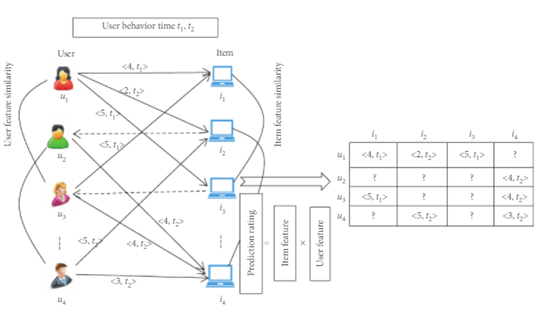

>The preceding plot provides an overview of a typical CNN.

>As observed from the structure proposed above, the recommender system depends on input from users. Primarily, the recommender system is built on the idea of predicting the ratings of a given user by analyzing the temporal dynamic features and the item features under the user’s time context that is to say, similar users with the same time context will have common preferences. therefore, it is very important for the CNN-based recommendation performance to choose similar users with the same context for the target user accurately.
>The recommender system based on the predicted ratings will then recommend the top 5 highly rated movies of the given user.


#### Data Preparation

> (1)- Merge the dataframes to obtain complete information regarding a user, a movie and the corresponding interaction.

> (2)- Split the data into test and train.

##### Merge the dataframes

In [1323]:
df_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [1324]:
df_movies.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [1325]:
#Merge the dataframes
movie_ratings = df_movies.merge(df_ratings)
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938
1,5,Father of the Bride Part II (1995),Comedy,31,3.0,850466642
2,5,Father of the Bride Part II (1995),Comedy,43,5.0,848994281
3,5,Father of the Bride Part II (1995),Comedy,45,3.0,959625102
4,5,Father of the Bride Part II (1995),Comedy,58,4.0,847719151


##### Split the dataframes to test and train sets

In [1326]:
X = movie_ratings[['userId', 'movieId']].values
y = movie_ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10024, 2), (4296, 2), (10024,), (4296,))

#### Modeling

We propose a deep learning collaborative recommender systems

**Analysis Steps:**  

1. Generate a index vector for all unique users and items
2. 70/30 Split the train data into test and train set
3. Generate a big 1/0 binary sparse matrix of User x items for training set
4. Run the model on the training set
5. Compute Mean Percentile Score on the test set prediction

**Why MPR**  
The data is in form of implicit feedback from users, implying that if a user interacted with an item, then it is an explicit action which we can observe but the abscence of an interaction can imply they either were not aware of the item, they did not like the item or that they just have yet to buy that item. 

Therefore, the MPR score will be computed using the average recommendation score (measured by percentile ranking) from each model.  0% is the best, 100% is the worst, anything over 50% is worse than random guessing.

>Select the item ids with the highest scores and pass them as recommendations for a user.

In [1327]:
X = movie_ratings[['userId', 'movieId']]
y = movie_ratings['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Step 1. Create a index vector for all unique users and movies

In [1328]:
#Order the items and users
c_movie = CategoricalDtype(sorted(movie_ratings['movieId'].unique()), ordered=True)
c_user = CategoricalDtype(sorted(movie_ratings['userId'].unique()), ordered=True)

In [1329]:
print(len(c_movie.categories))
print(len(c_user.categories))

2150
586


In [1330]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X, test_size=0.30, random_state=420)
print(train.shape)
print(test.shape)

(10024, 2)
(4296, 2)


In [1331]:
test = X_test.copy()
train = X_train.copy()

testw = test.copy()

testw['userId'] = test['userId'].astype(c_user)

testw['movieId'] = test['movieId'].astype(c_movie)

test_pred = testw.copy()

In [1332]:
testw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4296 entries, 533 to 2015
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   userId   4296 non-null   category
 1   movieId  4296 non-null   category
dtypes: category(2)
memory usage: 152.4 KB


### Step 2: Create a big 1/0 binary sparse matrix of User x items for training set

In [1333]:
from scipy.sparse import  csr_matrix
train_data = csr_matrix((np.ones(len(train)), (train['userId'].astype('category').cat.codes,
                                               train['movieId'].astype('category').cat.codes)), 
                  shape=( len(c_user.categories), len(c_movie.categories)))
print(f'{100*train_data.sum()/(train_data.shape[0]*train_data.shape[1])}% Sparsity')

0.7956186998968172% Sparsity


### Step 3. Run the model on the training set

Models were testing:

1. Simple Cosine Similarity on items

2. Non-negative matrix factorization

3. Simple Neural Collaborative Filtering


Evaluation:
- Recall: % of 1s in the Test set
- MPR: Mean Percentile Rank

#### Simple Cosine Similarity
Doing this in chunks for the test set so that we don't run into memory issues.   For the recall measure, if the track's relative percentile is < 0.5 then its a 1

In [1131]:
# Simple Cosine Similarity
from scipy.stats import percentileofscore
def model_simple(data, pred):
    from sklearn.metrics.pairwise import cosine_similarity
    # Model Simple: Cosine Similarity to obtain a matrix and then find closest based on the similarity matrix
    
    # normalize the matrix for each user (% importance to user)
    norm_data = data.multiply(1/data.sum(axis=1)).tocsr()
    # apply cosine similarity
    sim = cosine_similarity(norm_data.transpose(), dense_output=False)
    sim[np.diag_indices(sim.shape[0])] = 0
    denom = np.asarray(sim.sum(axis=1)).reshape(-1)

    # do it in chunks else we get memory error
    u_idx = pred['userId'].cat.codes.values
    i_idx = pred['movieId'].cat.codes.values

    n_chunks = 30
    chunks = np.array_split(np.arange(norm_data.shape[0]), n_chunks)
    res = []
    previous_max = 0
    for i,idx in enumerate(chunks):
        print(f'Doing Chunk {i+1}/{n_chunks}')
        score = (norm_data[idx].dot(sim)) / denom
        score = (-score).argsort() / denom.shape[0]
        sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
        chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
        res.append(chunk_score)
        previous_max = idx.max() + 1
    return np.concatenate(res)


# Evaluate model
model_pred = model_simple(train_data, testw)
mpr_cosine_sim = model_pred.sum()/len(testw)
print(f'MPR Score: {mpr_cosine_sim:.5f}')
rec_cosine_sim = (model_pred < 0.5).sum()/len(testw)
print(f'Recall Score: {rec_cosine_sim:.5f}')

Doing Chunk 1/30
Doing Chunk 2/30
Doing Chunk 3/30
Doing Chunk 4/30
Doing Chunk 5/30
Doing Chunk 6/30
Doing Chunk 7/30
Doing Chunk 8/30
Doing Chunk 9/30
Doing Chunk 10/30
Doing Chunk 11/30
Doing Chunk 12/30
Doing Chunk 13/30
Doing Chunk 14/30
Doing Chunk 15/30
Doing Chunk 16/30
Doing Chunk 17/30
Doing Chunk 18/30
Doing Chunk 19/30
Doing Chunk 20/30
Doing Chunk 21/30
Doing Chunk 22/30
Doing Chunk 23/30
Doing Chunk 24/30
Doing Chunk 25/30
Doing Chunk 26/30
Doing Chunk 27/30
Doing Chunk 28/30
Doing Chunk 29/30
Doing Chunk 30/30
MPR Score: 0.42323
Recall Score: 0.59451


#### Non-Negative Matrix Factorization

In [1132]:
from sklearn.decomposition import NMF, TruncatedSVD

def model_mf(data, pred, model):
    # normalize the matrix for each user (% importance to user)
    norm_data = data.multiply(1/data.sum(axis=1)).tocsr()
    W = model.fit_transform(norm_data)
    H = model.components_

    # do it in chunks else we get memory error
    u_idx = pred['userId'].cat.codes.values
    i_idx = pred['movieId'].cat.codes.values
    n_chunks = 30
    chunks = np.array_split(np.arange(W.shape[0]), n_chunks)
    res = []
    previous_max = 0
    for i,idx in enumerate(chunks):
        print(f'Doing Chunk {i+1}/{n_chunks}')
        score = (W[idx].dot(H))
        score = (-score).argsort() / score.shape[1]
        sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
        chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
        res.append(chunk_score)
        previous_max = idx.max() + 1
    return np.concatenate(res)

K = 2

# NMF
#NNDSVD with zeros filled with the average of X (better when sparsity is not desired)
model = NMF(n_components = K, init = 'nndsvd', max_iter = 1000, tol = 0.1, random_state = 1)
model_pred1 = model_mf(train_data, testw, model)
mpr_Non_Negative_Matrix_Factorization = model_pred1.sum()/len(testw)
print(f'NMF MPR Score: {mpr_Non_Negative_Matrix_Factorization:.5f}')
rec_Non_Negative_Matrix_Factorization = (model_pred1 < 0.5).sum()/len(testw)
print(f'Recall Score: {rec_Non_Negative_Matrix_Factorization:.5f}')

Doing Chunk 1/30
Doing Chunk 2/30
Doing Chunk 3/30
Doing Chunk 4/30
Doing Chunk 5/30
Doing Chunk 6/30
Doing Chunk 7/30
Doing Chunk 8/30
Doing Chunk 9/30
Doing Chunk 10/30
Doing Chunk 11/30
Doing Chunk 12/30
Doing Chunk 13/30
Doing Chunk 14/30
Doing Chunk 15/30
Doing Chunk 16/30
Doing Chunk 17/30
Doing Chunk 18/30
Doing Chunk 19/30
Doing Chunk 20/30
Doing Chunk 21/30
Doing Chunk 22/30
Doing Chunk 23/30
Doing Chunk 24/30
Doing Chunk 25/30
Doing Chunk 26/30
Doing Chunk 27/30
Doing Chunk 28/30
Doing Chunk 29/30
Doing Chunk 30/30
NMF MPR Score: 0.40487
Recall Score: 0.60521


#### Neural Collaborative Filtering

In [1133]:
# Create the Training Set
APPROX_NEGATIVE_SAMPLE_SIZE = int(len(train)*0.2)
n_users = c_user.categories.shape[0]
n_items = c_movie.categories.shape[0]
# Create Training Set
train_users = train['userId'].astype('category').cat.codes.values
train_items = train['movieId'].astype('category').cat.codes.values
train_labels = np.ones(len(train_users))
# insert negative samples
u = np.random.randint(n_users, size=APPROX_NEGATIVE_SAMPLE_SIZE)
i = np.random.randint(n_items, size=APPROX_NEGATIVE_SAMPLE_SIZE)
non_neg_idx = np.where(train_data[u,i] == 0)
train_users = np.concatenate([train_users, u[non_neg_idx[1]]])
train_items = np.concatenate([train_items, i[non_neg_idx[1]]])
train_labels = np.concatenate([train_labels, np.zeros(u[non_neg_idx[1]].shape[0])])
print((train_users.shape, train_items.shape, train_labels.shape))

# random shuffle the data (because Keras takes last 10% as validation split)
X = np.stack([train_users, train_items, train_labels], axis=1)
np.random.shuffle(X)

((12009,), (12009,), (12009,))


In [1439]:
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, merge
from keras.optimizers import RMSprop
from keras.regularizers import l2

def neural_network_model(num_users, num_items, latent_dim, regs=[0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()
    item_latent = Flatten()
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = merge.Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)

    return model

# create the model
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

model = neural_network_model(n_users, n_items, 50, regs = [0,0])

In [1135]:
model.summary()

Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        29300       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 50)        107500      item_input[0][0]                 
______________________________________________________________________________________

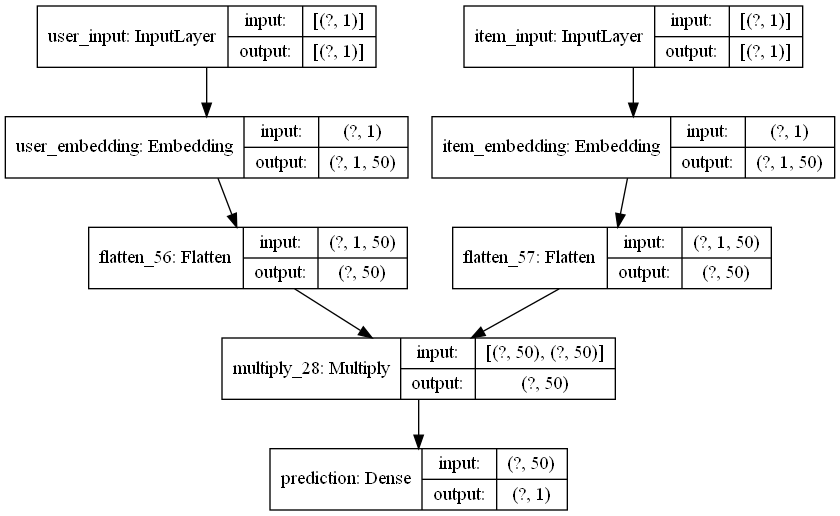

In [1136]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1137]:

model.compile(optimizer=RMSprop(lr=0.001), metrics = ['accuracy', recall],  loss='binary_crossentropy')

# Train Model
ES = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
hist = model.fit([X[:,0], X[:,1]], X[:,2], batch_size=150000, epochs=20, validation_split = 0.1, verbose=1, callbacks = [ES])
score = model.evaluate([testw['userId'].cat.codes.values, testw['movieId'].cat.codes.values], np.ones(testw.shape[0]), verbose=1, batch_size=100000)
print(f'Test Loss: {score[0]}   |   Test Recall: {score[1]}')

Epoch 1/20
1/1 [==============================] - 0s 297ms/step - loss: 0.6931 - accuracy: 0.4952 - recall: 0.4955 - val_loss: 0.6921 - val_accuracy: 0.8401 - val_recall: 0.9990
Epoch 2/20
1/1 [==============================] - 0s 20ms/step - loss: 0.6920 - accuracy: 0.8342 - recall: 1.0000 - val_loss: 0.6913 - val_accuracy: 0.8410 - val_recall: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 37ms/step - loss: 0.6912 - accuracy: 0.8340 - recall: 1.0000 - val_loss: 0.6906 - val_accuracy: 0.8410 - val_recall: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 20ms/step - loss: 0.6904 - accuracy: 0.8340 - recall: 1.0000 - val_loss: 0.6900 - val_accuracy: 0.8410 - val_recall: 1.0000
Epoch 00004: early stopping
1/1 [==============================] - 0s 976us/step - loss: 0.6886 - accuracy: 1.0000 - recall: 1.0000
Test Loss: 0.6886206865310669   |   Test Recall: 1.0


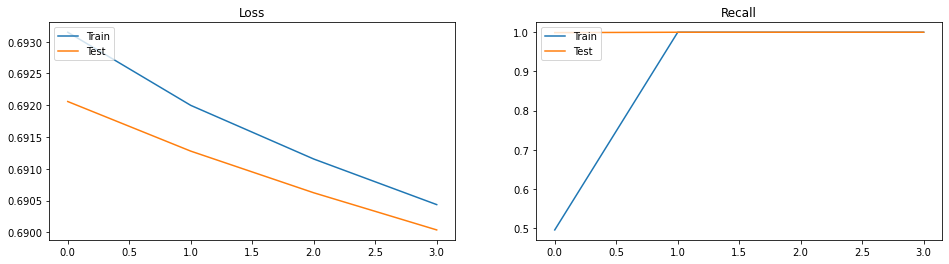

In [1138]:
# Plot it
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Loss')
ax1.legend(['Train', 'Test'], loc='upper left')
ax2.plot(hist.history['recall'])
ax2.plot(hist.history['val_recall'])
ax2.set_title('Recall')
ax2.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [1139]:

# Calculate MPR like before
# we do it in chunks else we get memory error
u_idx = testw['userId'].cat.codes.values
i_idx = testw['movieId'].cat.codes.values
n_chunks = 10
chunks = np.array_split(np.arange(n_users), n_chunks)
res = []
previous_max = 0
for i,idx in enumerate(chunks):
    print(f'Doing Chunk {i+1}/{n_chunks}')
    cross_movieId = np.transpose([np.tile(np.arange(n_items), len(idx)), np.repeat(idx, len(np.arange(n_items)))])
    score = model.predict([cross_movieId[:,1], cross_movieId[:,0]], batch_size=50000, verbose=1).reshape(idx.shape[0], n_items)
    score = (-score).argsort() / score.shape[1]
    sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
    chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
    res.append(chunk_score)
    previous_max = idx.max() + 1
mpr_NCF = np.concatenate(res).sum()/len(testw)
print(f'NCF MPR Score: {mpr_NCF:.5f}')
rec_NCF = (np.concatenate(res) < 0.5).sum()/len(testw)
print(f'NCF Recall Score: {rec_NCF:.5f}')

Doing Chunk 1/10
3/3 [==============================] - 0s 8ms/step
Doing Chunk 2/10
3/3 [==============================] - 0s 9ms/step
Doing Chunk 3/10
3/3 [==============================] - 0s 9ms/step
Doing Chunk 4/10
3/3 [==============================] - 0s 7ms/step
Doing Chunk 5/10
3/3 [==============================] - 0s 8ms/step
Doing Chunk 6/10
3/3 [==============================] - 0s 9ms/step
Doing Chunk 7/10
3/3 [==============================] - 0s 10ms/step
Doing Chunk 8/10
3/3 [==============================] - 0s 10ms/step
Doing Chunk 9/10
3/3 [==============================] - 0s 17ms/step
Doing Chunk 10/10
3/3 [==============================] - 0s 7ms/step
NCF MPR Score: 0.49279
NCF Recall Score: 0.50442


In [1140]:
#Make movie predictions using the deep learning model
test_pred['score'] = list(np.concatenate(res))
#Select the top 5 movieIds to recommend to a user
testf = test_pred.sort_values(['score'],ascending=False).groupby('userId').head(5)
testf1 = testf.sort_values('userId')
testf1 = testf1[['userId', 'movieId']]
testf1.columns = ['userId', 'Recommended movieId']
testf1.head(10)

,userId,Recommended movieId
4983,1,1954
898,1,223
3006,1,954
7524,1,3253
1901,1,441
13251,2,89774
11245,3,7899
3366,3,1124
7076,4,3083
3325,4,1103


# 10M MovieLens dataset

>Source: https://files.grouplens.org/datasets/movielens/ml-10m.zip

In [1334]:
# Reading ratings file
ratings = pd.read_csv('ml-10m/ratings.dat', sep='::',
                      names=['userId', 'movieId', 'rating', 'timestamp']
                      ).sort_values("timestamp")
# Reading movies file
movies = pd.read_csv('ml-10m/movies.dat', sep='::',
                     header=None, names=['movieId', 'title', 'genres'])

In [1342]:
df_movie = movies
df_ratings = ratings

In [1343]:
df_movies1 = df_movie.merge(df_ratings)[['genres', 'rating']]

#### Examine data sparsity

In [1344]:
users = list(np.sort(ratings.userId.unique())) # Get our unique customers
movies = list(ratings.movieId.unique()) # Get our unique products that were purchased
rating = list(ratings.rating) # All of our purchases
rows = ratings.userId.astype('category', users).cat.codes
# Get the associated row indices
cols = ratings.movieId.astype('category', movies).cat.codes
# Get the associated column indices
user_item = sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(movies)))
matrix_size = user_item.shape[0]*user_item.shape[1] # Number of possible interactions in the matrix
num_purchases = len(user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (1.0*num_purchases/matrix_size))
print(f'{round(sparsity,4)} % Sparsity')

98.6597 % Sparsity


In [1345]:
print(num_purchases, 'interactions')

10000054 interactions


In [1346]:
print(len(movies), 'Items')

10677 Items


In [1347]:
print(len(users), 'Users')

69878 Users


### Exploratory Data Analysis(EDA)

In [1348]:
df_movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of movie released

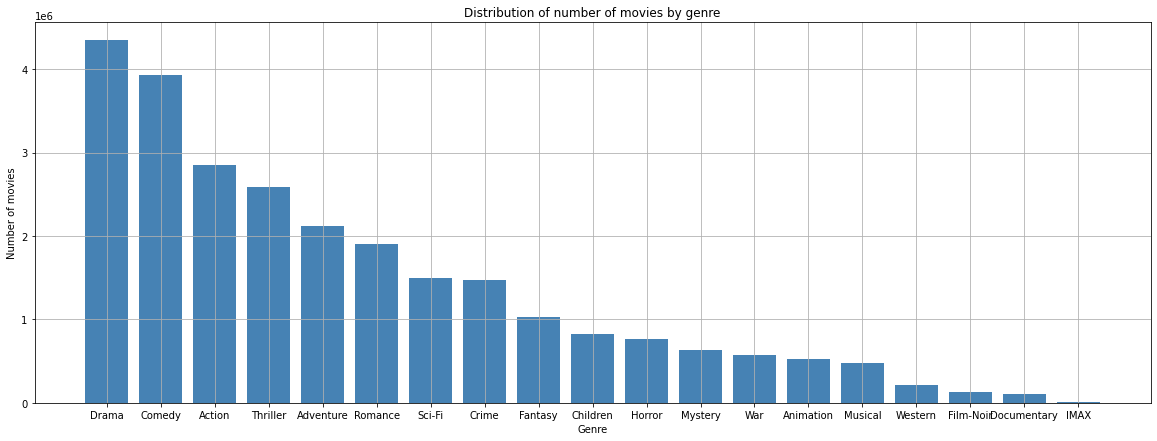

In [1349]:
plt.figure(figsize=(20,7))
genrelist = df_movies1['genres'].apply(lambda genrelist_movie : str(genrelist_movie).split("|"))
genres_count = {}

for genrelist_movie in genrelist:
    for genre in genrelist_movie:
        if(genres_count.get(genre,False)):
            genres_count[genre]=genres_count[genre]+1
        else:
            genres_count[genre] = 1
            
genres_count.pop('(no genres listed)')
genres_count = {k: v for k, v in sorted(genres_count.items(), key=lambda item: item[1], reverse=True)}
plt.bar(genres_count.keys(),genres_count.values(),color='steelblue')
plt.title('Distribution of number of movies by genre')
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.grid()
plt.show()

In [1350]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
5167075,36955,21,3.0,789652009
5167081,36955,47,5.0,789652009
5167124,36955,1079,3.0,789652009
4961485,35435,45,5.0,822873600
4961483,35435,21,5.0,822873600


### Distribution of users rating

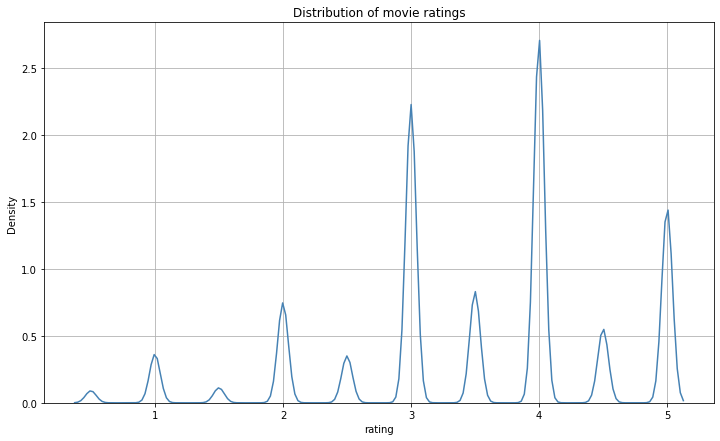

In [1351]:
plt.figure(figsize=(12,7))
sns.kdeplot(df_ratings["rating"], color = 'steelblue');
plt.title('Distribution of movie ratings')
plt.grid()
plt.show()

In [1352]:
print("Shape of the dataframes: \n"+ " Rating DataFrame: "+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movie.shape))

Shape of the dataframes: 
 Rating DataFrame: (10000054, 4)
 Movies DataFrame(10681, 3)


In [1353]:
merge_movie_ratings = pd.merge(df_movie, df_ratings, on='movieId', how='inner')

In [1354]:
merge_movie_ratings.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,35139,4.0,822873600
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,36008,5.0,823185203


In [1355]:
merge_movie_ratings = merge_movie_ratings.drop('timestamp', axis=1)

In [1356]:
merge_movie_ratings.shape

(10000054, 5)

Grouping the rating based on user

In [1357]:
ratings_grouped_by_users = merge_movie_ratings.groupby('userId').agg([np.size, np.mean])

In [1358]:
ratings_grouped_by_users.head(2)

movieId             rating     
          size        mean   size mean
userId                                
1           22  411.681818   22.0  5.0
2           20  785.550000   20.0  3.2

In [1359]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

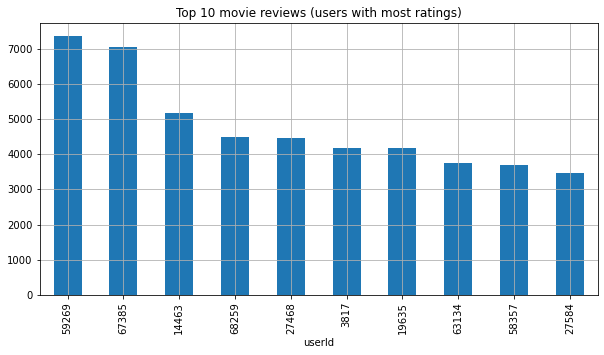

In [1360]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (10,5))
plt.title('Top 10 movie reviews (users with most ratings)')
plt.grid()
plt.show()

In [1361]:
ratings_grouped_by_movies = merge_movie_ratings.groupby('movieId').agg([np.mean], np.size)

In [1362]:
ratings_grouped_by_movies.shape

(10677, 2)

In [1363]:
ratings_grouped_by_movies.head(3)

,userId,rating
,mean,mean
movieId,,
1,35520.163787,3.928769
2,35868.424701,3.208070
3,35311.554685,3.150385


In [1364]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

### Movies with high average rating

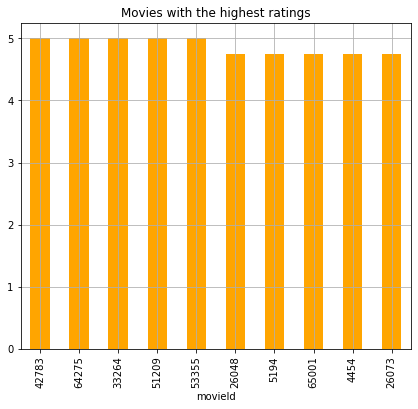

In [1365]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='bar',
                                                                                       figsize=(7,6), color = 'orange');
plt.title('Movies with the highest ratings')
plt.grid()
plt.show()

### Movies with low average rating

In [1366]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [1367]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

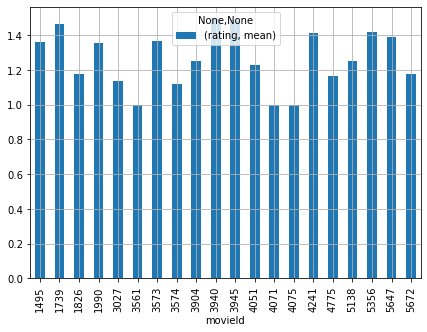

In [1368]:
low_rated_movies.head(20).plot(kind='bar', figsize=(7,5));
plt.grid()

In [1369]:
low_rated_movies.head(10)

,rating
,mean
movieId,
1495,1.360227
1739,1.464286
1826,1.175214
1990,1.356436
3027,1.138889
3561,1.000000
3573,1.367647
3574,1.120253


In [1370]:
#Merge
df_movies = df_movie.merge(df_ratings)

groupby = ['genres']
nonnormal = ['movieId']

df_movies = df_movies[df_movies['genres'].isin(list(genres_count.keys())[0:5])]

In [1371]:
mytable = TableOne(df_movies,columns = ['genres', 'rating'],
                   groupby=groupby, pval=True)

In [1372]:
mytable

Grouped by genres                                                                                            
                            Missing        Overall       Action   Adventure         Comedy          Drama      Thriller P-Value
n                                          1728711        27208        2549         778596         815084        105274        
rating, n (%) 0.5                 0    16147 (0.9)    428 (1.6)    53 (2.1)    11301 (1.5)     3895 (0.5)     470 (0.4)  <0.001
              1.0                      76002 (4.4)   2666 (9.8)   245 (9.6)    50350 (6.5)    19796 (2.4)    2945 (2.8)        
              1.5                      19674 (1.1)    614 (2.3)    62 (2.4)    13280 (1.7)     4938 (0.6)     780 (0.7)        
              2.0                     145057 (8.4)  3750 (13.8)  365 (14.3)   86532 (11.1)    46460 (5.7)    7950 (7.6)        
              2.5                      61721 (3.6)   1400 (5.1)   137 (5.4)    35875 (4.6)    20886 (2.6)    3423 (3.3)        
              3.0                    422363 (24.4)  9217 (33.9)  698 (27.4)  209441 (26.9)  175215 (21.5)  27792 (26.4)        
              3.5                     142369 (8.2)   1763 (6.5)   243 (9.5)    65123 (8.4)    66364 (8.1)    8876 (8.4)        
              4.0                    500639 (29.0)  5344 (19.6)  524 (20.6)  192115 (24.7)  267806 (32.9)  34850 (33.1)        
              4.5                      88418 (5.1)    434 (1.6)    69 (2.7)    31050 (4.0)    52679 (6.5)    4186 (4.0)        
              5.0                    256321 (14.8)   1592 (5.9)   153 (6.0)   83529 (10.7)  157045 (19.3)  14002 (13.3)

In [1373]:
mytable.to_excel('summary_10M.xlsx')

In [1374]:
mytable = TableOne(df_movies,columns = ['genres', 'rating'],
                   groupby=groupby, categorical=['genres'], nonnormal=nonnormal, pval=True, tukey_test=True)

display(mytable)

mytable.to_excel('summary_10M_test.xlsx')

Grouped by genres                                                                                                    
                                      Missing        Overall         Action     Adventure          Comedy           Drama        Thriller P-Value
n                                                    1728711          27208          2549          778596          815084          105274        
genres, n (%)     Action                    0    27208 (1.6)  27208 (100.0)                                                                <0.001
                  Adventure                       2549 (0.1)                 2549 (100.0)                                                        
                  Comedy                       778596 (45.0)                               778596 (100.0)                                        
                  Drama                        815084 (47.1)                                               815084 (100.0)                        
                  Thriller                      105274 (6.1)                                                               105274 (100.0)        
rating, mean (SD)                           0      3.5 (1.1)      2.9 (1.1)     3.0 (1.1)       3.2 (1.1)       3.7 (1.0)       3.5 (1.0)  <0.001
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: genres.

#### Data Preparation

> (1)- Merge the dataframes to obtain complete information regarding a user, a movie and the corresponding interaction.

> (2)- Split the data into test and train.

##### Merge the dataframes

In [1375]:
df_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [1376]:
df_movies.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [1377]:
#Merge the dataframes
movie_ratings = df_movies.merge(df_ratings)
movie_ratings = movie_ratings
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,5,Father of the Bride Part II (1995),Comedy,36008,2.0,823185224
1,5,Father of the Bride Part II (1995),Comedy,36304,4.0,823264601
2,5,Father of the Bride Part II (1995),Comedy,38104,4.0,825006881
3,5,Father of the Bride Part II (1995),Comedy,38206,2.0,825009968
4,5,Father of the Bride Part II (1995),Comedy,38326,4.0,825080156


##### Split the dataframes to test and train sets

In [1378]:
X = movie_ratings[['userId', 'movieId']].values
y = movie_ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1210097, 2), (518614, 2), (1210097,), (518614,))

#### Modeling

In [1379]:
X = movie_ratings[['userId', 'movieId']]
y = movie_ratings['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Step 1. Create a index vector for all unique users and movies

In [1380]:
#Order the items and users
c_movie = CategoricalDtype(sorted(movie_ratings['movieId'].unique()), ordered=True)
c_user = CategoricalDtype(sorted(movie_ratings['userId'].unique()), ordered=True)

In [1381]:
print(len(c_movie.categories))
print(len(c_user.categories))

3103
69076


In [1382]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X, test_size=0.30, random_state=420)
print(train.shape)
print(test.shape)

(1210097, 2)
(518614, 2)


In [1383]:
test = X_test.copy()
train = X_train.copy()

testw = test.copy()

testw['userId'] = test['userId'].astype(c_user)

testw['movieId'] = test['movieId'].astype(c_movie)

test_pred = testw.copy()

In [1384]:
testw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518614 entries, 1713321 to 710290
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   userId   518614 non-null  category
 1   movieId  518614 non-null  category
dtypes: category(2)
memory usage: 9.6 MB


### Step 2: Create a big 1/0 binary sparse matrix of User x items for training set

In [1385]:
from scipy.sparse import  csr_matrix
train_data = csr_matrix((np.ones(len(train)), (train['userId'].astype('category').cat.codes,
                                               train['movieId'].astype('category').cat.codes)), 
                  shape=( len(c_user.categories), len(c_movie.categories)))
print(f'{100*train_data.sum()/(train_data.shape[0]*train_data.shape[1])}% Sparsity')

0.564561460390921% Sparsity


### Step 3. Run the model on the training set

Models were testing:

1. Simple Cosine Similarity on items

2. Non-negative matrix factorization

3. Simple Neural Collaborative Filtering


Evaluation:
- Recall: % of 1s in the Test set
- MPR: Mean Percentile Rank

#### Simple Cosine Similarity
Doing this in chunks for the test set so that we don't run into memory issues.   For the recall measure, if the track's relative percentile is < 0.5 then its a 1

In [1386]:
# Simple Cosine Similarity
from scipy.stats import percentileofscore
def model_simple(data, pred):
    from sklearn.metrics.pairwise import cosine_similarity
    # Model Simple: Cosine Similarity to obtain a matrix and then find closest based on the similarity matrix
    
    # normalize the matrix for each user (% importance to user)
    norm_data = data.multiply(1/data.sum(axis=1)).tocsr()
    # apply cosine similarity
    sim = cosine_similarity(norm_data.transpose(), dense_output=False)
    sim[np.diag_indices(sim.shape[0])] = 0
    denom = np.asarray(sim.sum(axis=1)).reshape(-1)

    # do it in chunks else we get memory error
    u_idx = pred['userId'].cat.codes.values
    i_idx = pred['movieId'].cat.codes.values

    n_chunks = 30
    chunks = np.array_split(np.arange(norm_data.shape[0]), n_chunks)
    res = []
    previous_max = 0
    for i,idx in enumerate(chunks):
        print(f'Doing Chunk {i+1}/{n_chunks}')
        score = (norm_data[idx].dot(sim)) / denom
        score = (-score).argsort() / denom.shape[0]
        sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
        chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
        res.append(chunk_score)
        previous_max = idx.max() + 1
    return np.concatenate(res)


# Evaluate model
model_pred = model_simple(train_data, testw)
mpr_cosine_sim = model_pred.sum()/len(testw)
print(f'MPR Score: {mpr_cosine_sim:.5f}')
rec_cosine_sim = (model_pred < 0.5).sum()/len(testw)
print(f'Recall Score: {rec_cosine_sim:.5f}')

Doing Chunk 1/30
Doing Chunk 2/30
Doing Chunk 3/30
Doing Chunk 4/30
Doing Chunk 5/30
Doing Chunk 6/30
Doing Chunk 7/30
Doing Chunk 8/30
Doing Chunk 9/30
Doing Chunk 10/30
Doing Chunk 11/30
Doing Chunk 12/30
Doing Chunk 13/30
Doing Chunk 14/30
Doing Chunk 15/30
Doing Chunk 16/30
Doing Chunk 17/30
Doing Chunk 18/30
Doing Chunk 19/30
Doing Chunk 20/30
Doing Chunk 21/30
Doing Chunk 22/30
Doing Chunk 23/30
Doing Chunk 24/30
Doing Chunk 25/30
Doing Chunk 26/30
Doing Chunk 27/30
Doing Chunk 28/30
Doing Chunk 29/30
Doing Chunk 30/30
MPR Score: 0.40586
Recall Score: 0.64690


#### Non-Negative Matrix Factorization

In [1387]:
from sklearn.decomposition import NMF, TruncatedSVD

def model_mf(data, pred, model):
    # normalize the matrix for each user (% importance to user)
    norm_data = data.multiply(1/data.sum(axis=1)).tocsr()
    W = model.fit_transform(norm_data)
    H = model.components_

    # do it in chunks else we get memory error
    u_idx = pred['userId'].cat.codes.values
    i_idx = pred['movieId'].cat.codes.values
    n_chunks = 30
    chunks = np.array_split(np.arange(W.shape[0]), n_chunks)
    res = []
    previous_max = 0
    for i,idx in enumerate(chunks):
        print(f'Doing Chunk {i+1}/{n_chunks}')
        score = (W[idx].dot(H))
        score = (-score).argsort() / score.shape[1]
        sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
        chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
        res.append(chunk_score)
        previous_max = idx.max() + 1
    return np.concatenate(res)

K = 2

# NMF
#NNDSVD with zeros filled with the average of X (better when sparsity is not desired)
model = NMF(n_components = K, init = 'nndsvd', max_iter = 1000, tol = 0.1, random_state = 1)
model_pred1 = model_mf(train_data, testw, model)
mpr_Non_Negative_Matrix_Factorization = model_pred1.sum()/len(testw)
print(f'NMF MPR Score: {mpr_Non_Negative_Matrix_Factorization:.5f}')
rec_Non_Negative_Matrix_Factorization = (model_pred1 < 0.5).sum()/len(testw)
print(f'Recall Score: {rec_Non_Negative_Matrix_Factorization:.5f}')

Doing Chunk 1/30
Doing Chunk 2/30
Doing Chunk 3/30
Doing Chunk 4/30
Doing Chunk 5/30
Doing Chunk 6/30
Doing Chunk 7/30
Doing Chunk 8/30
Doing Chunk 9/30
Doing Chunk 10/30
Doing Chunk 11/30
Doing Chunk 12/30
Doing Chunk 13/30
Doing Chunk 14/30
Doing Chunk 15/30
Doing Chunk 16/30
Doing Chunk 17/30
Doing Chunk 18/30
Doing Chunk 19/30
Doing Chunk 20/30
Doing Chunk 21/30
Doing Chunk 22/30
Doing Chunk 23/30
Doing Chunk 24/30
Doing Chunk 25/30
Doing Chunk 26/30
Doing Chunk 27/30
Doing Chunk 28/30
Doing Chunk 29/30
Doing Chunk 30/30
NMF MPR Score: 0.37234
Recall Score: 0.69477


#### Neural Collaborative Filtering

In [1388]:
# Create the Training Set
APPROX_NEGATIVE_SAMPLE_SIZE = int(len(train)*0.2)
n_users = c_user.categories.shape[0]
n_items = c_movie.categories.shape[0]
# Create Training Set
train_users = train['userId'].astype('category').cat.codes.values
train_items = train['movieId'].astype('category').cat.codes.values
train_labels = np.ones(len(train_users))
# insert negative samples
u = np.random.randint(n_users, size=APPROX_NEGATIVE_SAMPLE_SIZE)
i = np.random.randint(n_items, size=APPROX_NEGATIVE_SAMPLE_SIZE)
non_neg_idx = np.where(train_data[u,i] == 0)
train_users = np.concatenate([train_users, u[non_neg_idx[1]]])
train_items = np.concatenate([train_items, i[non_neg_idx[1]]])
train_labels = np.concatenate([train_labels, np.zeros(u[non_neg_idx[1]].shape[0])])
print((train_users.shape, train_items.shape, train_labels.shape))

# random shuffle the data (because Keras takes last 10% as validation split)
X = np.stack([train_users, train_items, train_labels], axis=1)
np.random.shuffle(X)

((1450762,), (1450762,), (1450762,))


In [1389]:
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, merge
from keras.optimizers import RMSprop
from keras.regularizers import l2

def neural_network_model(num_users, num_items, latent_dim, regs=[0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', 
                                  embeddings_regularizer = l2(regs[0]), input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                  embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = merge.Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)

    return model

# create the model
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

model = neural_network_model(n_users, n_items, 50, regs = [0,0])

In [1390]:
model.summary()

Model: "functional_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        3453800     user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 50)        155150      item_input[0][0]                 
______________________________________________________________________________________

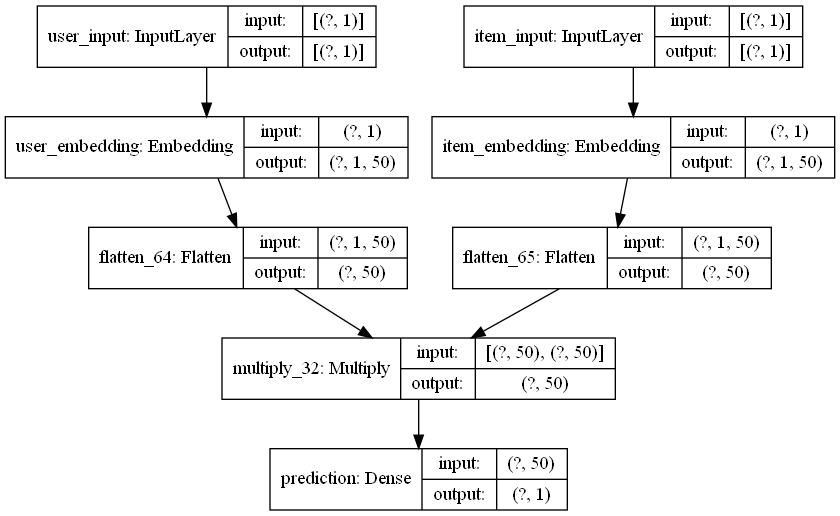

In [1391]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1392]:

model.compile(optimizer=RMSprop(lr=0.001), metrics = ['accuracy', recall],  loss='binary_crossentropy')

# Train Model
ES = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
hist = model.fit([X[:,0], X[:,1]], X[:,2], batch_size=150000, epochs=20, validation_split = 0.1, verbose=1, callbacks = [ES])
score = model.evaluate([testw['userId'].cat.codes.values, testw['movieId'].cat.codes.values], np.ones(testw.shape[0]), verbose=1, batch_size=100000)
print(f'Test Loss: {score[0]}   |   Test Recall: {score[1]}')

Epoch 1/20
9/9 [==============================] - 2s 270ms/step - loss: 0.6904 - accuracy: 0.7955 - recall: 0.9444 - val_loss: 0.6878 - val_accuracy: 0.8351 - val_recall: 1.0000
Epoch 2/20
9/9 [==============================] - 2s 257ms/step - loss: 0.6863 - accuracy: 0.8340 - recall: 1.0000 - val_loss: 0.6844 - val_accuracy: 0.8351 - val_recall: 1.0000
Epoch 3/20
9/9 [==============================] - 2s 216ms/step - loss: 0.6831 - accuracy: 0.8340 - recall: 1.0000 - val_loss: 0.6813 - val_accuracy: 0.8351 - val_recall: 1.0000
Epoch 4/20
9/9 [==============================] - 2s 210ms/step - loss: 0.6800 - accuracy: 0.8340 - recall: 1.0000 - val_loss: 0.6783 - val_accuracy: 0.8351 - val_recall: 1.0000
Epoch 00004: early stopping
6/6 [==============================] - 0s 35ms/step - loss: 0.6709 - accuracy: 1.0000 - recall: 1.0000
Test Loss: 0.6709297299385071   |   Test Recall: 1.0


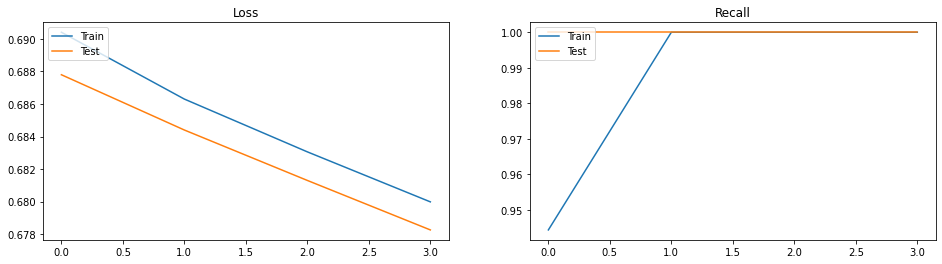

In [1393]:
# Plot it
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Loss')
ax1.legend(['Train', 'Test'], loc='upper left')
ax2.plot(hist.history['recall'])
ax2.plot(hist.history['val_recall'])
ax2.set_title('Recall')
ax2.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [1394]:

# Calculate MPR like before
# we do it in chunks else we get memory error
u_idx = testw['userId'].cat.codes.values
i_idx = testw['movieId'].cat.codes.values
n_chunks = 10
chunks = np.array_split(np.arange(n_users), n_chunks)
res = []
previous_max = 0
for i,idx in enumerate(chunks):
    print(f'Doing Chunk {i+1}/{n_chunks}')
    cross_movieId = np.transpose([np.tile(np.arange(n_items), len(idx)), np.repeat(idx, len(np.arange(n_items)))])
    score = model.predict([cross_movieId[:,1], cross_movieId[:,0]], batch_size=50000, verbose=1).reshape(idx.shape[0], n_items)
    score = (-score).argsort() / score.shape[1]
    sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
    chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
    res.append(chunk_score)
    previous_max = idx.max() + 1
mpr_NCF = np.concatenate(res).sum()/len(testw)
print(f'NCF MPR Score: {mpr_NCF:.5f}')
rec_NCF = (np.concatenate(res) < 0.5).sum()/len(testw)
print(f'NCF Recall Score: {rec_NCF:.5f}')

Doing Chunk 1/10
429/429 [==============================] - 9s 22ms/step
Doing Chunk 2/10
429/429 [==============================] - 10s 23ms/step
Doing Chunk 3/10
429/429 [==============================] - 8s 19ms/step
Doing Chunk 4/10
429/429 [==============================] - 8s 19ms/step
Doing Chunk 5/10
429/429 [==============================] - 9s 20ms/step
Doing Chunk 6/10
429/429 [==============================] - 7s 16ms/step
Doing Chunk 7/10
429/429 [==============================] - 8s 18ms/step
Doing Chunk 8/10
429/429 [==============================] - 8s 18ms/step
Doing Chunk 9/10
429/429 [==============================] - 7s 17ms/step
Doing Chunk 10/10
429/429 [==============================] - 8s 18ms/step
NCF MPR Score: 0.49250
NCF Recall Score: 0.51197


In [1395]:
#Make movie predictions using the deep learning model
test_pred['score'] = list(np.concatenate(res))
#Select the top 5 movieIds to recommend to a user
testf = test_pred.sort_values(['score'],ascending=False).groupby('userId').head(5)
testf1 = testf.sort_values('userId')
testf1 = testf1[['userId', 'movieId']]
testf1.columns = ['userId', 'Recommended movieId']
testf1.head(10)

,userId,Recommended movieId
676471,3,1276
158401,4,231
330433,4,410
677414,5,1280
451962,5,538
221329,5,306
625960,5,1207
633980,5,1225
630097,7,1207
918395,7,2335


# "Learning from sets data 2019" DATA:

>Source: https://grouplens.org/datasets/learning-from-sets-of-items-2019/

In [1396]:
# Reading ratings file
movie_ratings = pd.read_csv('learning-from-sets-2019/item_ratings.csv',
                      names=['userId', 'movieId', 'rating', 'timestamp']
                      ).sort_values("timestamp")
#Drop rows that have nonnumeric movie ID
movie_ratings = movie_ratings[movie_ratings.movieId.str.isnumeric().isnull()]
#Convert data types for movieId and rating
movie_ratings['movieId'] = pd.to_numeric(movie_ratings.movieId)
movie_ratings['rating'] = pd.to_numeric(movie_ratings.rating)

# Reading movies file
movie_1 = pd.read_csv('learning-from-sets-2019/set_ratings.csv')

In [1397]:
movies_1 = movie_ratings.copy()
users = list(np.sort(movie_ratings.userId.unique())) # Get our unique customers
movies_1 = list(movie_ratings.movieId.unique()) # Get our unique products that were purchased
rating = list(movie_ratings.rating) # All of our purchases
rows = movie_ratings.userId.astype('category', users).cat.codes
# Get the associated row indices
cols = movie_ratings.movieId.astype('category', movies_1).cat.codes
# Get the associated column indices
user_item = sparse.csr_matrix((rating, (rows, cols)), shape=(len(users), len(movies_1)))
matrix_size = user_item.shape[0]*user_item.shape[1] # Number of possible interactions in the matrix
num_purchases = len(user_item.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (1.0*num_purchases/matrix_size))
print(f'{round(sparsity,4)} % Sparsity')

96.4581 % Sparsity


In [1398]:
movie_ratings.head()

,userId,movieId,rating,timestamp
131258,1861f05e46,2001,3.5,2005-03-29 16:19:32
131132,1861f05e46,1250,3.5,2005-03-29 16:20:20
131105,1861f05e46,1204,3.5,2005-03-29 16:20:33
131235,1861f05e46,1876,3.0,2005-03-29 16:21:37
131600,1861f05e46,4886,5.0,2005-03-29 16:21:41


In [1399]:
print(num_purchases, 'interactions')

print(len(movies_1), 'Items')

print(len(users), 'Users')

327899 interactions
12443 Items
744 Users


In [1400]:
movie_ratings.head()

,userId,movieId,rating,timestamp
131258,1861f05e46,2001,3.5,2005-03-29 16:19:32
131132,1861f05e46,1250,3.5,2005-03-29 16:20:20
131105,1861f05e46,1204,3.5,2005-03-29 16:20:33
131235,1861f05e46,1876,3.0,2005-03-29 16:21:37
131600,1861f05e46,4886,5.0,2005-03-29 16:21:41


## Exploratory Data Analysis(EDA)

In [1401]:
X = movie_ratings[['userId', 'movieId',]]
y = movie_ratings['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1402]:
df_movies.head(5)

,movieId,title,genres,userId,rating,timestamp
48035,5,Father of the Bride Part II (1995),Comedy,36008,2.0,823185224
48036,5,Father of the Bride Part II (1995),Comedy,36304,4.0,823264601
48037,5,Father of the Bride Part II (1995),Comedy,38104,4.0,825006881
48038,5,Father of the Bride Part II (1995),Comedy,38206,2.0,825009968
48039,5,Father of the Bride Part II (1995),Comedy,38326,4.0,825080156


### Distribution of users rating

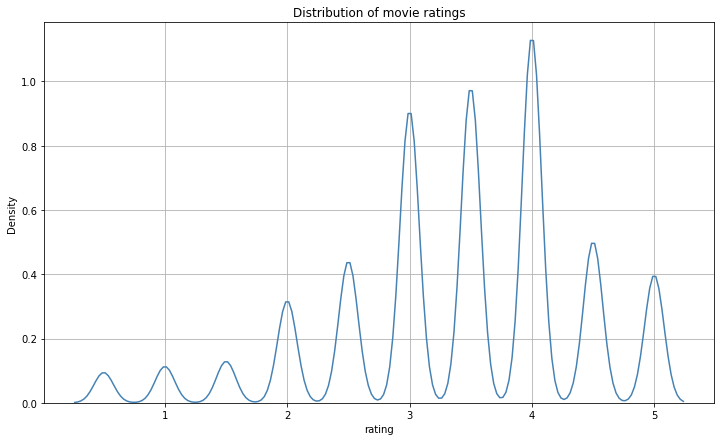

In [1403]:
plt.figure(figsize=(12,7))
sns.kdeplot(movie_ratings["rating"], color = 'steelblue');
plt.title('Distribution of movie ratings')
plt.grid()
plt.show()

In [1404]:
df_ratings = df_movies = movie_ratings
df_ratings.head(5)

,userId,movieId,rating,timestamp
131258,1861f05e46,2001,3.5,2005-03-29 16:19:32
131132,1861f05e46,1250,3.5,2005-03-29 16:20:20
131105,1861f05e46,1204,3.5,2005-03-29 16:20:33
131235,1861f05e46,1876,3.0,2005-03-29 16:21:37
131600,1861f05e46,4886,5.0,2005-03-29 16:21:41


In [1405]:
print("Shape of the dataframes: \n"+ " Rating DataFrame: "+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

Shape of the dataframes: 
 Rating DataFrame: (327899, 4)
 Movies DataFrame(327899, 4)


In [1406]:
ratings_grouped_by_users = movie_ratings.groupby('userId').agg([np.size, np.mean])

In [1407]:
ratings_grouped_by_users.head(2)

movieId               rating          
              size          mean   size      mean
userId                                           
0011a9baea     172  53528.569767  172.0  4.151163
00be0326d6     277  34154.996390  277.0  2.444043

In [1408]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

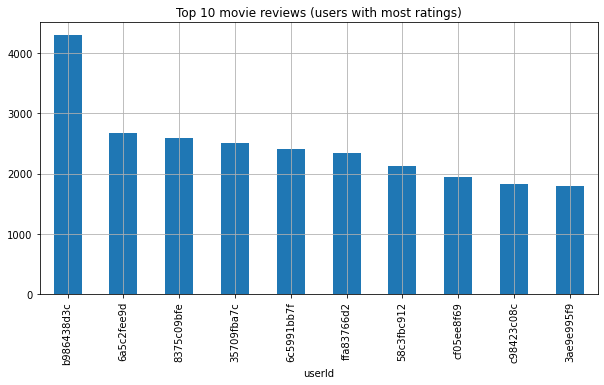

In [1409]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (10,5))
plt.title('Top 10 movie reviews (users with most ratings)')
plt.grid()
plt.show()

In [1410]:
ratings_grouped_by_movies = movie_ratings.groupby('movieId').agg([np.mean], np.size)

In [1411]:
ratings_grouped_by_movies.shape

(12443, 1)

In [1412]:
ratings_grouped_by_movies.head(3)

,rating
,mean
movieId,
1,3.727064
2,3.172340
3,3.068966


### Movies with high average rating

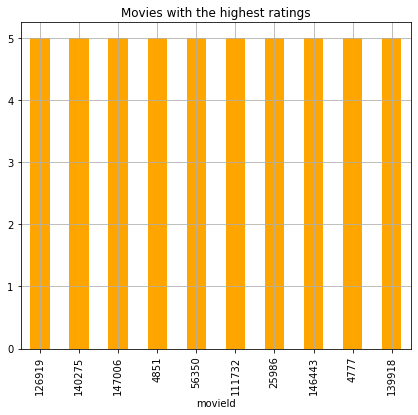

In [1413]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='bar', figsize=(7,6), color = 'orange');
plt.title('Movies with the highest ratings')
plt.grid()
plt.show()

### Movies with low average rating

In [1414]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [1415]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

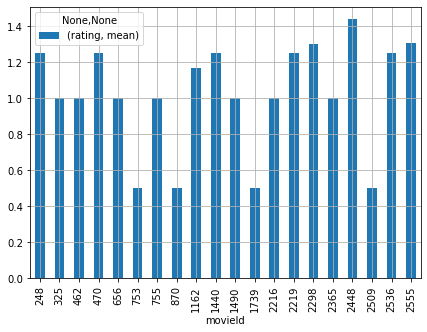

In [1416]:
low_rated_movies.head(20).plot(kind='bar', figsize=(7,5));
plt.grid()

In [1417]:
low_rated_movies.head(10)

,rating
,mean
movieId,
248,1.250000
325,1.000000
462,1.000000
470,1.250000
656,1.000000
753,0.500000
755,1.000000
870,0.500000


##### Merge the dataframes

In [1418]:
df_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [1419]:
df_movies.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [1420]:
#Merge the dataframes
movie_ratings = df_movies
movie_ratings.head()

,userId,movieId,rating,timestamp
131258,1861f05e46,2001,3.5,2005-03-29 16:19:32
131132,1861f05e46,1250,3.5,2005-03-29 16:20:20
131105,1861f05e46,1204,3.5,2005-03-29 16:20:33
131235,1861f05e46,1876,3.0,2005-03-29 16:21:37
131600,1861f05e46,4886,5.0,2005-03-29 16:21:41


##### Split the dataframes to test and train sets

In [1421]:
X = movie_ratings[['userId', 'movieId']].values
y = movie_ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((229529, 2), (98370, 2), (229529,), (98370,))

In [1422]:
X = movie_ratings[['userId', 'movieId']]
y = movie_ratings['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Step 1. Create a index vector for all unique users and movies

In [1423]:
#Order the items and users
c_movie = CategoricalDtype(sorted(movie_ratings['movieId'].unique()), ordered=True)
c_user = CategoricalDtype(sorted(movie_ratings['userId'].unique()), ordered=True)

In [1424]:
print(len(c_movie.categories))
print(len(c_user.categories))

12443
744


In [1425]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(X, test_size=0.30, random_state=420)
print(train.shape)
print(test.shape)

(229529, 2)
(98370, 2)


In [1426]:
test = X_test.copy()
train = X_train.copy()

testw = test.copy()

testw['userId'] = test['userId'].astype(c_user)

testw['movieId'] = test['movieId'].astype(c_movie)

test_pred = testw.copy()

In [1427]:
testw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98370 entries, 447372 to 304033
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   userId   98370 non-null  category
 1   movieId  98370 non-null  category
dtypes: category(2)
memory usage: 1.5 MB


### Step 2: Create a big 1/0 binary sparse matrix of User x items for training set

In [1428]:

train_data = csr_matrix((np.ones(len(train)), (train['userId'].astype('category').cat.codes, train['movieId'].astype('category').cat.codes)), 
                  shape=( len(c_user.categories), len(c_movie.categories)))
print(f'{100*train_data.sum()/(train_data.shape[0]*train_data.shape[1])}% Sparsity')

2.4793596434148317% Sparsity


### Step 3. Run the model on the training set

Models were testing:

1. Simple Cosine Similarity on items

2. Non-negative matrix factorization

3. Simple Neural Collaborative Filtering


Evaluation:
- Recall: % of 1s in the Test set
- MPR: Mean Percentile Rank

#### Simple Cosine Similarity
Doing this in chunks for the test set so that we don't run into memory issues.   For the recall measure, if the track's relative percentile is < 0.5 then its a 1

In [1429]:
# Simple Cosine Similarity

def model_simple(data, pred):
    from sklearn.metrics.pairwise import cosine_similarity
    # Model Simple: Cosine Similarity to obtain a matrix and then find closest based on the similarity matrix
    
    # normalize the matrix for each user (% importance to user)
    norm_data = data.multiply(1/data.sum(axis=1)).tocsr()
    # apply cosine similarity
    sim = cosine_similarity(norm_data.transpose(), dense_output=False)
    sim[np.diag_indices(sim.shape[0])] = 0
    denom = np.asarray(sim.sum(axis=1)).reshape(-1)

    # do it in chunks else we get memory error
    u_idx = pred['userId'].cat.codes.values
    i_idx = pred['movieId'].cat.codes.values

    n_chunks = 30
    chunks = np.array_split(np.arange(norm_data.shape[0]), n_chunks)
    res = []
    previous_max = 0
    for i,idx in enumerate(chunks):
        print(f'Doing Chunk {i+1}/{n_chunks}')
        score = (norm_data[idx].dot(sim)) / denom
        score = (-score).argsort() / denom.shape[0]
        sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
        chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
        res.append(chunk_score)
        previous_max = idx.max() + 1
    return np.concatenate(res)


# Evaluate model
model_pred = model_simple(train_data, testw)
mpr_cosine_sim = model_pred.sum()/len(testw)
print(f'MPR Score: {mpr_cosine_sim:.5f}')
rec_cosine_sim = (model_pred < 0.5).sum()/len(testw)
print(f'Recall Score: {rec_cosine_sim:.5f}')

Doing Chunk 1/30
Doing Chunk 2/30
Doing Chunk 3/30
Doing Chunk 4/30
Doing Chunk 5/30
Doing Chunk 6/30
Doing Chunk 7/30
Doing Chunk 8/30
Doing Chunk 9/30
Doing Chunk 10/30
Doing Chunk 11/30
Doing Chunk 12/30
Doing Chunk 13/30
Doing Chunk 14/30
Doing Chunk 15/30
Doing Chunk 16/30
Doing Chunk 17/30
Doing Chunk 18/30
Doing Chunk 19/30
Doing Chunk 20/30
Doing Chunk 21/30
Doing Chunk 22/30
Doing Chunk 23/30
Doing Chunk 24/30
Doing Chunk 25/30
Doing Chunk 26/30
Doing Chunk 27/30
Doing Chunk 28/30
Doing Chunk 29/30
Doing Chunk 30/30
MPR Score: 0.47469
Recall Score: 0.52412


#### Non-Negative Matrix Factorization

In [1430]:


def model_mf(data, pred, model):
    # normalize the matrix for each user (% importance to user)
    norm_data = data.multiply(1/data.sum(axis=1)).tocsr()
    W = model.fit_transform(norm_data)
    H = model.components_

    # do it in chunks else we get memory error
    u_idx = pred['userId'].cat.codes.values
    i_idx = pred['movieId'].cat.codes.values
    n_chunks = 30
    chunks = np.array_split(np.arange(W.shape[0]), n_chunks)
    res = []
    previous_max = 0
    for i,idx in enumerate(chunks):
        print(f'Doing Chunk {i+1}/{n_chunks}')
        score = (W[idx].dot(H))
        score = (-score).argsort() / score.shape[1]
        sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
        chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
        res.append(chunk_score)
        previous_max = idx.max() + 1
    return np.concatenate(res)

K = 2

# NMF
model = NMF(n_components = K, init = 'nndsvd', max_iter = 1000, tol = 0.1)
model_pred1 = model_mf(train_data, testw, model)
mpr_Non_Negative_Matrix_Factorization = model_pred1.sum()/len(testw)
print(f'NMF MPR Score: {mpr_Non_Negative_Matrix_Factorization:.5f}')
rec_Non_Negative_Matrix_Factorization = (model_pred1 < 0.5).sum()/len(testw)
print(f'Recall Score: {rec_Non_Negative_Matrix_Factorization:.5f}')

Doing Chunk 1/30
Doing Chunk 2/30
Doing Chunk 3/30
Doing Chunk 4/30
Doing Chunk 5/30
Doing Chunk 6/30
Doing Chunk 7/30
Doing Chunk 8/30
Doing Chunk 9/30
Doing Chunk 10/30
Doing Chunk 11/30
Doing Chunk 12/30
Doing Chunk 13/30
Doing Chunk 14/30
Doing Chunk 15/30
Doing Chunk 16/30
Doing Chunk 17/30
Doing Chunk 18/30
Doing Chunk 19/30
Doing Chunk 20/30
Doing Chunk 21/30
Doing Chunk 22/30
Doing Chunk 23/30
Doing Chunk 24/30
Doing Chunk 25/30
Doing Chunk 26/30
Doing Chunk 27/30
Doing Chunk 28/30
Doing Chunk 29/30
Doing Chunk 30/30
NMF MPR Score: 0.46404
Recall Score: 0.53403


#### Neural Collaborative Filtering

In [1431]:
# Create the Training Set
APPROX_NEGATIVE_SAMPLE_SIZE = int(len(train)*0.2)
n_users = c_user.categories.shape[0]
n_items = c_movie.categories.shape[0]
# Create Training Set
train_users = train['userId'].astype('category').cat.codes.values
train_items = train['movieId'].astype('category').cat.codes.values
train_labels = np.ones(len(train_users))
# insert negative samples
u = np.random.randint(n_users, size=APPROX_NEGATIVE_SAMPLE_SIZE)
i = np.random.randint(n_items, size=APPROX_NEGATIVE_SAMPLE_SIZE)
non_neg_idx = np.where(train_data[u,i] == 0)
train_users = np.concatenate([train_users, u[non_neg_idx[1]]])
train_items = np.concatenate([train_items, i[non_neg_idx[1]]])
train_labels = np.concatenate([train_labels, np.zeros(u[non_neg_idx[1]].shape[0])])
print((train_users.shape, train_items.shape, train_labels.shape))

# random shuffle the data (because Keras takes last 10% as validation split)
X = np.stack([train_users, train_items, train_labels], axis=1)
np.random.shuffle(X)

((274298,), (274298,), (274298,))


In [1441]:
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Reshape, Flatten, merge
from keras.optimizers import RMSprop
from keras.regularizers import l2

def neural_network_model(num_users, num_items, latent_dim, regs=[0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', embeddings_regularizer = l2(regs[0]), input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', embeddings_regularizer = l2(regs[1]), input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = merge.Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)

    return model

# create the model
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

model = neural_network_model(n_users, n_items, 50, regs = [0,0])

In [1442]:
model.summary()

Model: "functional_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 10, 50)       37200       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 10, 50)       622150      item_input[0][0]                 
______________________________________________________________________________________

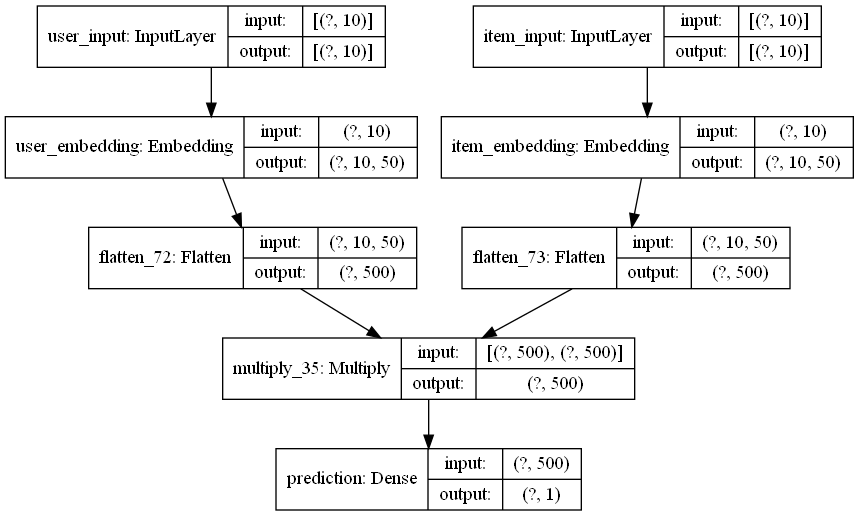

In [1443]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [1435]:

model.compile(optimizer=RMSprop(lr=0.001), metrics = ['accuracy', recall],  loss='binary_crossentropy')

# Train Model
ES = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
hist = model.fit([X[:,0], X[:,1]], X[:,2], batch_size=150000, epochs=20, validation_split = 0.1, verbose=1, callbacks = [ES])
score = model.evaluate([testw['userId'].cat.codes.values, testw['movieId'].cat.codes.values], np.ones(testw.shape[0]), verbose=1, batch_size=100000)
print(f'Test Loss: {score[0]}   |   Test Recall: {score[1]}')

Epoch 1/20
2/2 [==============================] - 0s 184ms/step - loss: 0.6927 - accuracy: 0.6330 - recall: 0.7502 - val_loss: 0.6913 - val_accuracy: 0.8347 - val_recall: 1.0000
Epoch 2/20
2/2 [==============================] - 0s 66ms/step - loss: 0.6910 - accuracy: 0.8370 - recall: 1.0000 - val_loss: 0.6901 - val_accuracy: 0.8347 - val_recall: 1.0000
Epoch 3/20
2/2 [==============================] - 0s 77ms/step - loss: 0.6899 - accuracy: 0.8370 - recall: 1.0000 - val_loss: 0.6891 - val_accuracy: 0.8347 - val_recall: 1.0000
Epoch 4/20
2/2 [==============================] - 0s 59ms/step - loss: 0.6889 - accuracy: 0.8370 - recall: 1.0000 - val_loss: 0.6882 - val_accuracy: 0.8347 - val_recall: 1.0000
Epoch 00004: early stopping
1/1 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 1.0000 - recall: 1.0000
Test Loss: 0.6857763528823853   |   Test Recall: 1.0


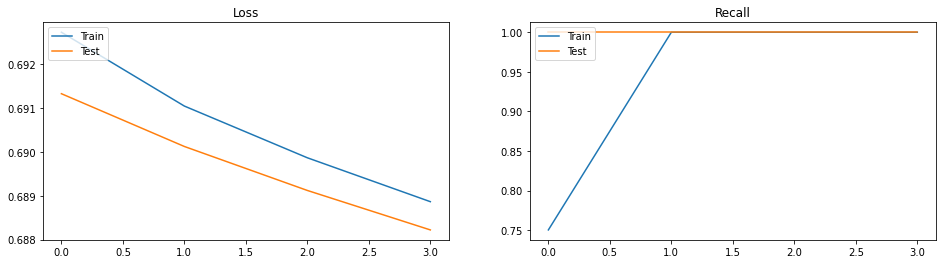

In [1436]:
# Plot it
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Loss')
ax1.legend(['Train', 'Test'], loc='upper left')
ax2.plot(hist.history['recall'])
ax2.plot(hist.history['val_recall'])
ax2.set_title('Recall')
ax2.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [1437]:

# Calculate MPR like before
# we do it in chunks else we get memory error
u_idx = testw['userId'].cat.codes.values
i_idx = testw['movieId'].cat.codes.values
n_chunks = 10
chunks = np.array_split(np.arange(n_users), n_chunks)
res = []
previous_max = 0
for i,idx in enumerate(chunks):
    print(f'Doing Chunk {i+1}/{n_chunks}')
    cross_movieId = np.transpose([np.tile(np.arange(n_items), len(idx)), np.repeat(idx, len(np.arange(n_items)))])
    score = model.predict([cross_movieId[:,1], cross_movieId[:,0]], batch_size=50000, verbose=1).reshape(idx.shape[0], n_items)
    score = (-score).argsort() / score.shape[1]
    sel = (u_idx >= idx.min()) & (u_idx <= idx.max())
    chunk_score = np.asarray(score[u_idx[sel] - previous_max, i_idx[sel]]).reshape(-1)
    res.append(chunk_score)
    previous_max = idx.max() + 1
mpr_NCF = np.concatenate(res).sum()/len(testw)
print(f'NCF MPR Score: {mpr_NCF:.5f}')
rec_NCF = (np.concatenate(res) < 0.5).sum()/len(testw)
print(f'NCF Recall Score: {rec_NCF:.5f}')

Doing Chunk 1/10
19/19 [==============================] - 0s 16ms/step
Doing Chunk 2/10
19/19 [==============================] - 0s 14ms/step
Doing Chunk 3/10
19/19 [==============================] - 0s 16ms/step
Doing Chunk 4/10
19/19 [==============================] - 1s 28ms/step
Doing Chunk 5/10
19/19 [==============================] - 0s 14ms/step
Doing Chunk 6/10
19/19 [==============================] - 0s 26ms/step
Doing Chunk 7/10
19/19 [==============================] - 0s 19ms/step
Doing Chunk 8/10
19/19 [==============================] - 1s 29ms/step
Doing Chunk 9/10
19/19 [==============================] - 1s 32ms/step
Doing Chunk 10/10
19/19 [==============================] - 0s 15ms/step
NCF MPR Score: 0.49794
NCF Recall Score: 0.50034


In [1438]:
#Make movie predictions using the deep learning model
test_pred['score'] = list(np.concatenate(res))
#Select the top 5 movieIds to recommend to a user
testf = test_pred.sort_values(['score'],ascending=False).groupby('userId').head(5)
testf1 = testf.sort_values('userId')
testf1 = testf1[['userId', 'movieId']]
testf1.columns = ['userId', 'Recommended movieId']
testf1.head(10)

,userId,Recommended movieId
376832,0011a9baea,113345
376753,0011a9baea,8970
376825,0011a9baea,111375
376706,0011a9baea,2409
376744,0011a9baea,7254
452642,00be0326d6,126919
452639,00be0326d6,117517
452458,00be0326d6,2396
452496,00be0326d6,4979
452530,00be0326d6,8368
